In [1]:
# mounting the data through drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Import Necessary Libraries

In [2]:

import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import gc
from matplotlib import rcParams
import itertools
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve,roc_curve,auc
from sklearn.metrics import fbeta_score, make_scorer

rcParams['figure.figsize'] = 10,8
plt.style.use('ggplot')


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Load dataset

In [0]:
#include path for data
df = pd.read_csv("/content/drive/My Drive/Info Viz/TriagingDataset.csv",sep = ";",error_bad_lines=False) 

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (309,356,357,369,375,385,397,444,445,457,463,473,485,532,533,545,551,561,566,573,574,575,584,586,588,590,591,594,595,596,602,620,621,622,623,624,629,630,631,634,638,639,645,649,680,681,682,683,684,714) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
#print(df.shape)
#drop the unwanted column 'Unnamed:0'
df = df.drop('Unnamed: 0', 1)
#print(df.shape)

In [0]:
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = [str(x).replace(',', '.') for x in df[col]]

Exploratory Data Analysis and Preprocessing

189

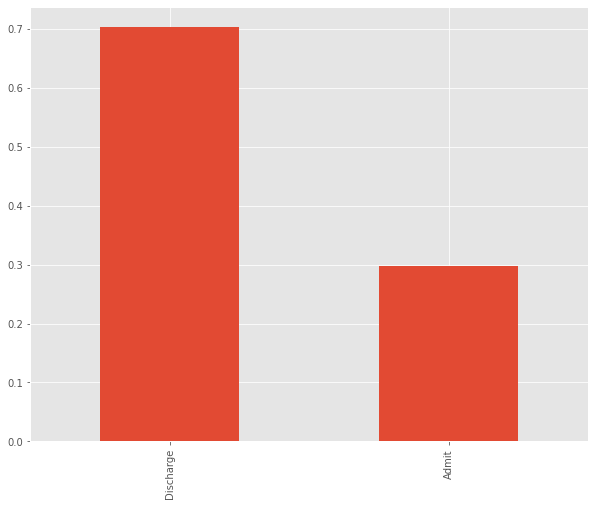

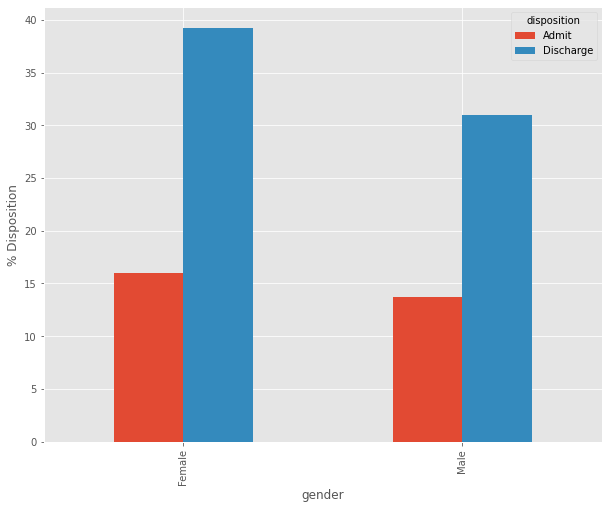

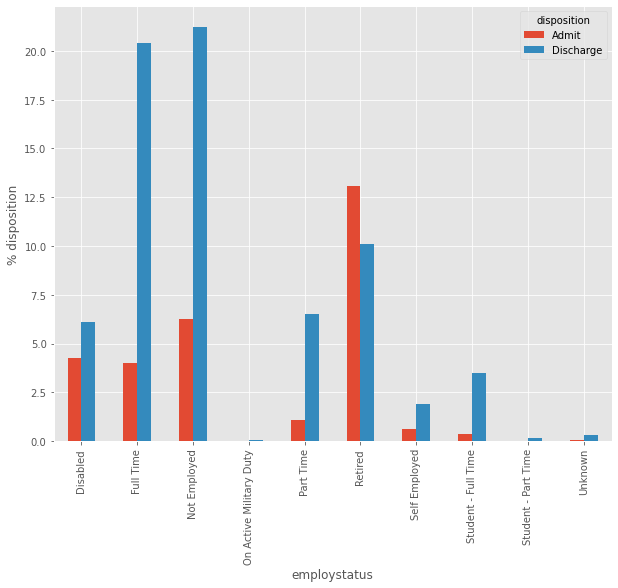

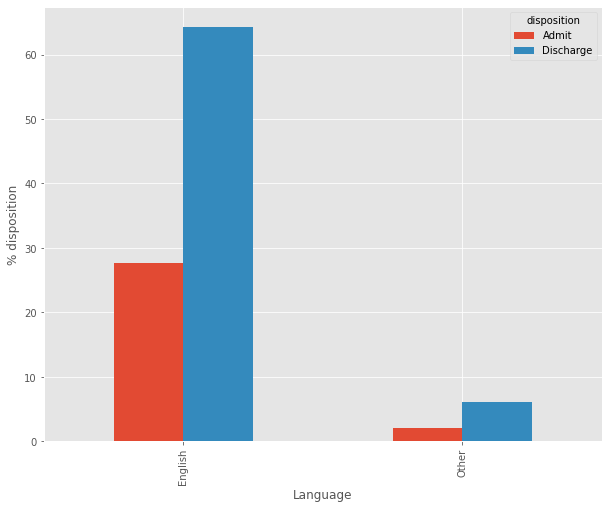

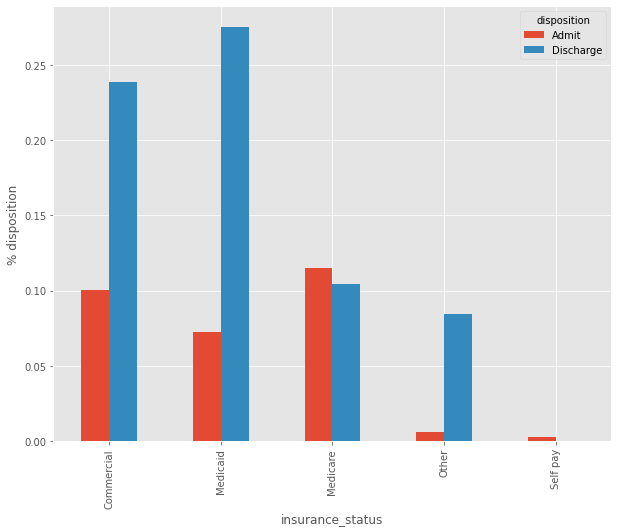

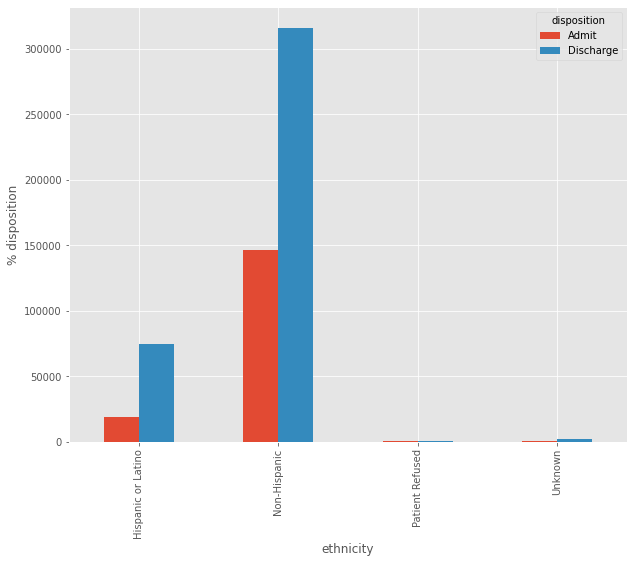

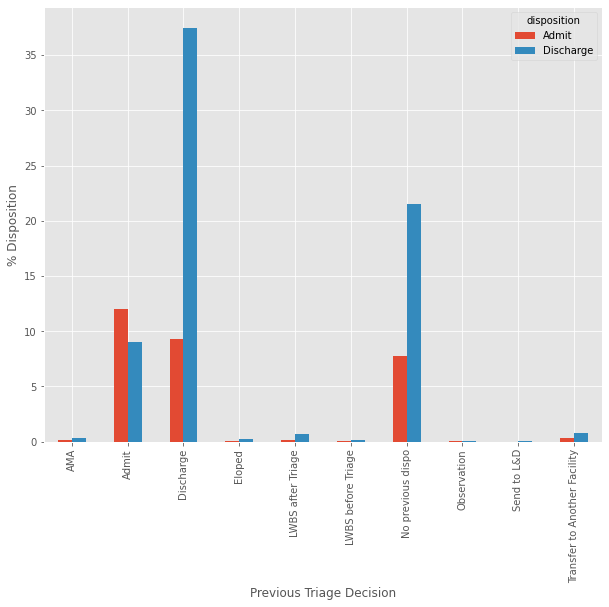

In [0]:
"""
Steps:
1.convert numerical strings to actual integers
2.Plot distribution of data points wrt disposition
3.Check trends in data
4.Aggregating columns with less contribution to admission rate as 'Others'
5.Localised imputation of data
6.Memory reduction of dataset
"""
# Replace ',' with '.'(decimal) in values present in each column
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = [str(x).replace(',', '.') for x in df[col]]

# Distribution of labels and renaming labels 'Discharge' as 0 and 'Admit' as 1
df['disposition'].value_counts(normalize=True).plot(kind = "bar")
df['disposition'].replace({'Discharge': '0', 'Admit': '1'})

#Distribtion of Disposition wrt Gender
df_gender = df.groupby(['gender','disposition']).size().transform(lambda x: x/sum(x)*100).unstack().plot.bar()
df_gender.set_ylabel("% Disposition")


#Distribtion of Disposition wrt Employee status
df_employ = df.groupby(['employstatus','disposition']).size().transform(lambda x: x/sum(x)*100).unstack().plot.bar()
df_employ.set_ylabel("% disposition")

#Distribtion of Disposition wrt Language
df_lang = df.groupby(['lang','disposition']).size().transform(lambda x: x/sum(x)*100).unstack().plot.bar()
df_lang.set_ylabel("% disposition")
df_lang.set_xlabel("Language")

#Distribtion of Disposition wrt insurance_status
df_insurance = df.groupby(['insurance_status','disposition']).size().transform(lambda x: x/sum(x)).unstack().plot.bar()
df_insurance.set_ylabel("% disposition")

#Distribtion of Disposition wrt ethnicity
df_ethinicity = df.groupby(['ethnicity','disposition']).size().unstack().plot.bar()
df_ethinicity.set_ylabel("% disposition")

#Distribtion of Disposition wrt previous disposition
df_predisposition = df.groupby(['previousdispo','disposition']).size().transform(lambda x: x/sum(x)*100).unstack().plot.bar()
df_predisposition.set_xlabel("Previous Triage Decision")
df_predisposition.set_ylabel("% Disposition")

del df_gender
del df_employ
del df_ethinicity
del df_insurance
del df_lang
del df_predisposition
gc.collect()

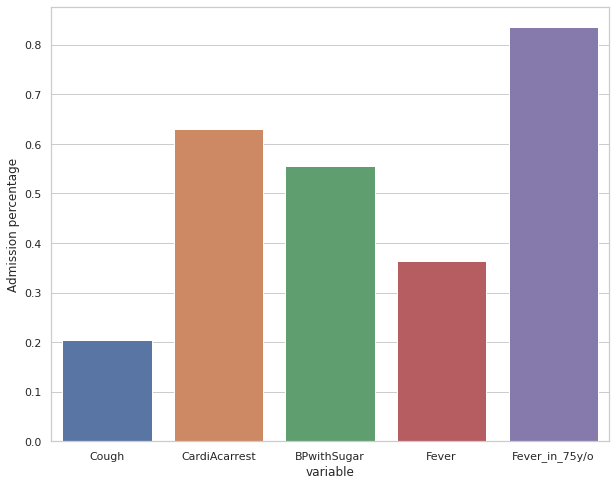

In [0]:
#Percentage of Admissions wrt Disease
disease_df = pd.DataFrame({'Cough' : df['cc_cough'][(df['disposition'] == 'Admit') & (df['cc_cough'] == 1)].value_counts()/df['cc_cough'][(df['cc_cough'] == 1)].value_counts(),
                          'CardiAcarrest' : df['cc_cardiacarrest'][(df['disposition'] == 'Admit') &(df['cc_cardiacarrest'] == 1)].value_counts()/df['cc_cardiacarrest'][(df['cc_cardiacarrest'] == 1)].value_counts(),
                          'BPwithSugar' : df['cc_elevatedbloodsugar-symptomatic'][(df['disposition'] == 'Admit') & (df['cc_elevatedbloodsugar-symptomatic'] == 1)].value_counts()/df['cc_elevatedbloodsugar-symptomatic'][(df['cc_elevatedbloodsugar-symptomatic'] == 1)].value_counts(),
                          'Fever' : df['cc_fever'][(df['disposition'] == 'Admit') &(df['cc_fever'] == 1)].value_counts()/df['cc_fever'][(df['cc_fever'] == 1)].value_counts(),
                           'Fever_in_75y/o' : df['cc_fever-75yearsorolder'][(df['disposition'] == 'Admit') &(df['cc_fever-75yearsorolder'] == 1)].value_counts()/df['cc_fever-75yearsorolder'][(df['cc_fever-75yearsorolder'] == 1)].value_counts()})

melt_df = pd.melt(disease_df, value_vars=['Cough', 'CardiAcarrest' , 'BPwithSugar', 'Fever', 'Fever_in_75y/o'])
del disease_df
ax = sns.barplot(x="variable", y="value", data=melt_df)
ax.set(ylabel='Admission percentage')
del melt_df


6215

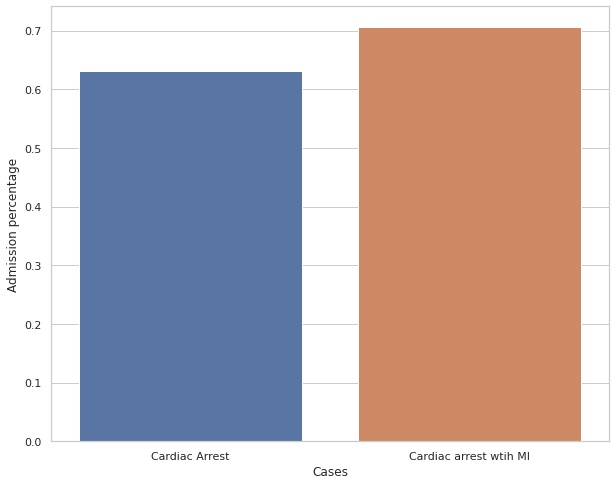

In [0]:
# Percentage of Admissions wrt Cardiac Cases
cardiac_cases = pd.DataFrame({'Cases' : ['Cardiac Arrest', 'Cardiac arrest wtih MI'],
    'values' : [df['cc_cardiacarrest'][(df['disposition'] == 'Admit') & (df['cc_cardiacarrest'] == 1)].value_counts()/df['cc_cardiacarrest'][(df['cc_cardiacarrest'] == 1)].value_counts(),
                df['cc_cardiacarrest'][(df['disposition'] == 'Admit') &  (df['acutemi'] == 1) & (df['cc_cardiacarrest'] == 1)].value_counts()/df['cc_cardiacarrest'][(df['cc_cardiacarrest'] == 1) & (df['acutemi'] == 1)].value_counts()]})

sns.set(style="whitegrid")

ax = sns.barplot(x="Cases", y="values", data=cardiac_cases)
ax.set(ylabel='Admission percentage')
del cardiac_cases

gc.collect()

/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


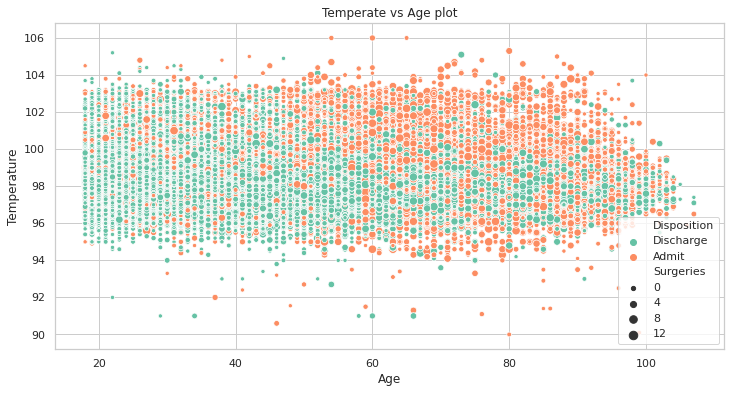

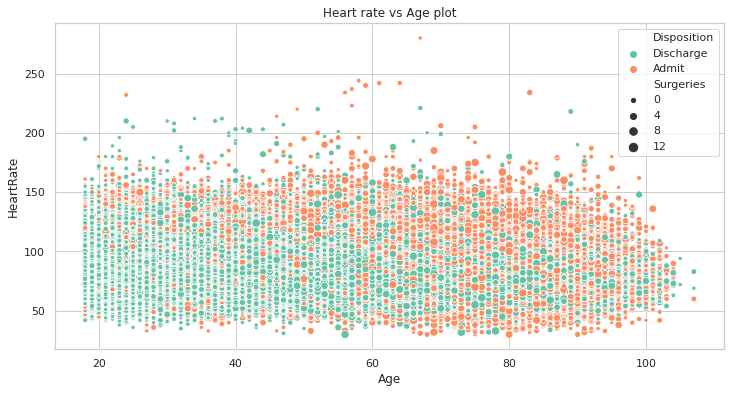

5758

In [0]:
temp = pd.DataFrame({"Temperature" : [round(float(val),2) for val in list(df['triage_vital_temp'])], "Age" : df['age'],
                     "Disposition" : df['disposition'],
                    "HeartRate" : [round(float(val),2) for val in list(df['triage_vital_hr'])],
                    "Surgeries" : df['n_surgeries']})
temp["Surgeries"] = np.where(temp["Surgeries"].to_numpy() > 10, 11, temp["Surgeries"].to_numpy()).tolist()

# Trends in Temperature wrt Age
cmap = sns.cubehelix_palette(dark=.2, light=.9, as_cmap=True)
plt.figure(figsize= (12,6))
ax = sns.scatterplot(x="Age", y="Temperature",
                     hue="Disposition", size = "Surgeries",
                     palette="Set2",
                     data=temp)

plt.title('Temperate vs Age plot')
plt.show()

# Trends in Heart Rate wrt Age
plt.figure(figsize= (12,6))
ax = sns.scatterplot(x="Age", y="HeartRate",
                     hue="Disposition", size = "Surgeries",
                     palette="Set2",
                     data=temp)

plt.title('Heart rate vs Age plot')
plt.show()
del temp
gc.collect()

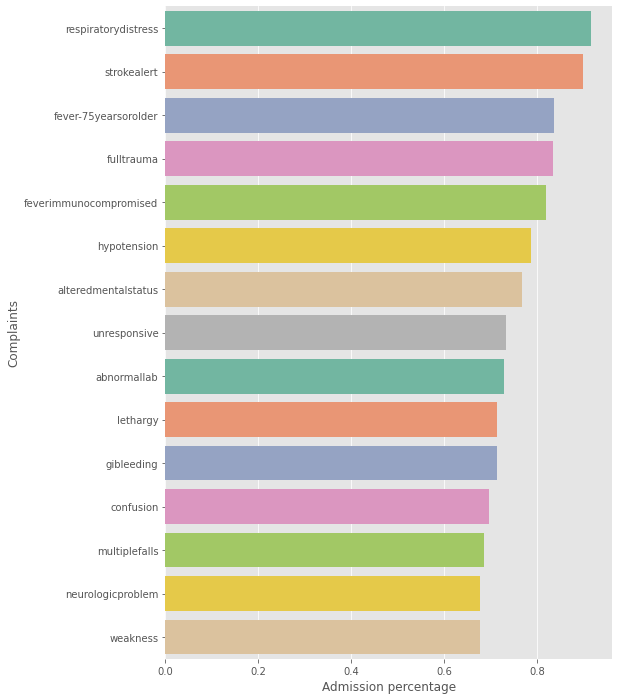

In [0]:
#  chief compaints- Eliminate columns which has admit rate < 10%


chief_complaints = [cc for cc in df.columns if 'cc_' in cc]
top_cc = df[chief_complaints].sum()
## Number of observation in chief complaints where the disposition = Admit
top_cc_admit = df[chief_complaints][df['disposition'] == 'Admit'].sum()
top_cc_admit_percent = top_cc_admit/top_cc

## Plot of top 15 complaints with highest admission rate
selected_cc = pd.DataFrame({"Admit Percentage" : top_cc_admit_percent, "Complaints" : [comp.split('_')[-1] for comp in top_cc_admit_percent.index]})
selected_cc.reset_index(drop = True, inplace = True)
selected_cc = selected_cc.sort_values('Admit Percentage')[::-1][:15]
plt.figure(figsize= (8,12))
ax = sns.barplot(y="Complaints", x="Admit Percentage", palette="Set2", data=selected_cc)
ax.set(xlabel='Admission percentage')
sns.despine(left=True, bottom=True)
plt.show()
del selected_cc
gc.collect()
## Keep columns which has admit rate >= 10%.
np.where(top_cc_admit_percent.sort_values().values >0.1)
columns_to_fuse = top_cc_admit_percent.sort_values().index[0:60]
columns_to_keep = top_cc_admit_percent.sort_values().index[60:200]

top_cc_admit_percent.sort_values()



reduced_df = df.drop(columns_to_fuse, axis = 1)
reduced_df['cc_others'] = df[columns_to_fuse].sum(axis=1)



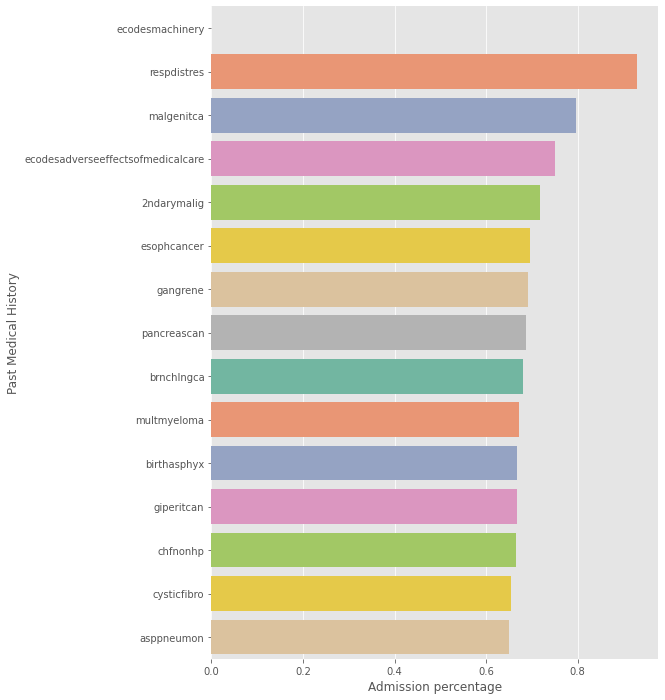

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in greater


In [0]:
#past medical records
all_past_medical_cols = [
    '2ndarymalig','abdomhernia','abdomnlpain','abortcompl','acqfootdef','acrenlfail','acutecvd','acutemi','acutphanm',
    'adjustmentdisorders','adltrespfl','alcoholrelateddisorders','allergy','amniosdx','analrectal','anemia','aneurysm',
    'anxietydisorders','appendicitis','artembolism','asppneumon','asthma','attentiondeficitconductdisruptivebeha','backproblem',
    'biliarydx','birthasphyx','birthtrauma','bladdercncr','blindness','bnignutneo','bonectcncr','bph','brainnscan','breastcancr',
    'breastdx','brnchlngca','bronchitis','burns','cardiaarrst','cardiacanom','carditis','cataract','cervixcancr','chestpain',
    'chfnonhp','chrkidneydisease','coaghemrdx','coloncancer','comabrndmg','complicdevi','complicproc','conduction','contraceptiv',
    'copd','coronathero','crushinjury','cysticfibro','deliriumdementiaamnesticothercognitiv','developmentaldisorders','diabmelnoc',
    'diabmelwcm','disordersusuallydiagnosedininfancych','diverticulos','dizziness','dminpreg','dysrhythmia','earlylabor',
    'ecodesadverseeffectsofmedicalcare','ecodesadverseeffectsofmedicaldrugs','ecodescutpierce','ecodesdrowningsubmersion',
    'ecodesfall','ecodesfirearm','ecodesfireburn','ecodesmachinery','ecodesmotorvehicletrafficmvt','ecodesnaturalenvironment',
    'ecodesotherspecifiedandclassifiable','ecodesotherspecifiednec','ecodespedalcyclistnotmvt','ecodesplaceofoccurrence',
    'ecodespoisoning','ecodesstruckbyagainst','ecodessuffocation','ecodestransportnotmvt','ecodesunspecified','ectopicpreg',
    'encephalitis','endometrios','epilepsycnv','esophcancer','esophgealdx','exameval','eyeinfectn','fatigue','femgenitca',
    'feminfertil','fetaldistrs','fluidelcdx','fuo','fxarm','fxhip','fxleg','fxskullfac','gangrene','gasduoulcer','gastritis',
    'gastroent','giconganom','gihemorrhag','giperitcan','glaucoma','goutotcrys','guconganom','hdnckcancr','headachemig',
    'hemmorhoids','hemorrpreg','hepatitis','hivinfectn','hodgkinsds','hrtvalvedx','htn','htncomplicn','htninpreg','hyperlipidem',
    'immunitydx','immunizscrn','impulsecontroldisordersnec','inducabortn','infectarth','influenza','infmalegen','intestinfct',
    'intobstruct','intracrninj','jointinjury','kidnyrnlca','lateeffcvd','leukemias','liveborn','liveribdca','longpregncy',
    'lowbirthwt','lungexternl','lymphenlarg','maintchemr','malgenitca','maligneopls','malposition','meningitis','menopausldx',
    'menstrualdx','miscellaneousmentalhealthdisorders','mooddisorders','mouthdx','ms','multmyeloma','mycoses','nauseavomit',
    'neoplsmunsp','nephritis','nervcongan','nonepithca','nonhodglym','nutritdefic','obrelatedperintrauma','opnwndextr',
    'opnwndhead','osteoarthros','osteoporosis','otacqdefor','otaftercare','otbnignneo','otbonedx','otcirculdx','otcomplbir',
    'otconganom','otconntiss','otdxbladdr','otdxkidney','otdxstomch','otendodsor','otfemalgen','othbactinf','othcnsinfx',
    'othematldx','othercvd','othereardx','otheredcns','othereyedx','othergidx','othergudx','otherinjury',
    'otherpregnancyanddeliveryincludingnormal','otherscreen','othfracture','othheartdx','othinfectns','othliverdx',
    'othlowresp','othmalegen','othnervdx','othskindx','othveindx','otinflskin','otitismedia','otjointdx','otnutritdx',
    'otperintdx','otpregcomp','otprimryca','otrespirca','otupprresp','otuprspin','ovariancyst','ovarycancer','pancreascan',
    'pancreasdx','paralysis','parkinsons','pathologfx','pelvicobstr','perintjaund','peripathero','peritonitis',
    'personalitydisorders','phlebitis','pid','pleurisy','pneumonia','poisnnonmed','poisnotmed','poisonpsych','precereoccl',
    'prevcsectn','prolapse','prostatecan','pulmhartdx','rctmanusca','rehab','respdistres','retinaldx','rheumarth',
    'schizophreniaandotherpsychoticdisorde','screeningandhistoryofmentalhealthan','septicemia','septicemiaexceptinlabor',
    'sexualinfxs','shock','sicklecell','skininfectn','skinmelanom','sle','socialadmin','spincorinj','spontabortn','sprain',
    'stomchcancr','substancerelateddisorders','suicideandintentionalselfinflictedin','superficinj','syncope','teethdx',
    'testiscancr','thyroidcncr','thyroiddsor','tia','tonsillitis','tuberculosis','ulceratcol','ulcerskin','umbilcord',
    'unclassified','urinstone',
    'urinyorgca','uteruscancr','uti','varicosevn','viralinfect','whtblooddx'
]


## Number of records in past medical history where disposition = Admit
top_pmh = df[all_past_medical_cols].sum()
top_pmh_admit =  df[all_past_medical_cols][ df['disposition'] == 'Admit'].sum()
top_pmh_admit_percent = top_pmh_admit/top_pmh

## Plot of top 15 complaints with highest admission rate

selected_pmh = pd.DataFrame({"Admit Percentage" : top_pmh_admit_percent, "Complaints" : [comp.split('_')[-1] for comp in top_pmh_admit_percent.index]})
selected_pmh.reset_index(drop = True, inplace = True)
selected_pmh = selected_pmh.sort_values('Admit Percentage')[::-1][:15]

plt.figure(figsize= (8,12))
ax = sns.barplot(y="Complaints", x="Admit Percentage", palette="Set2", data=selected_pmh)
ax.set(xlabel='Admission percentage')
ax.set(ylabel='Past Medical History')
sns.despine(left=True, bottom=True)
plt.show()
del selected_pmh
gc.collect()
np.where(top_pmh_admit_percent.sort_values().values >0.3)
columns_to_fuse_pmh = top_pmh_admit_percent.sort_values().index[:60]

reduced_df['pmh_others'] = reduced_df[columns_to_fuse_pmh].sum(axis=1)
reduced_df = reduced_df.drop(columns_to_fuse_pmh, axis = 1)





/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


90

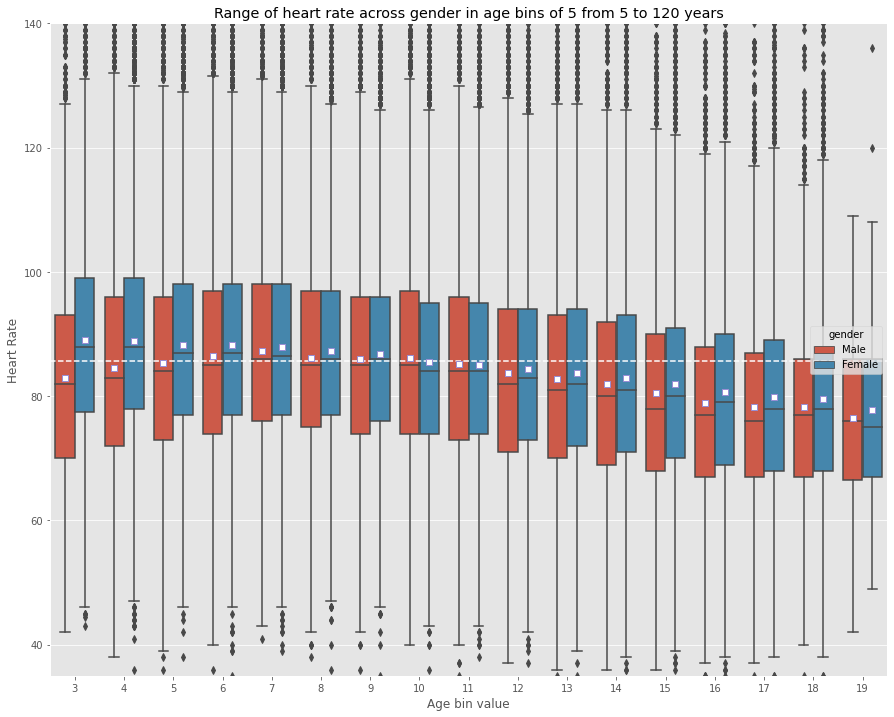

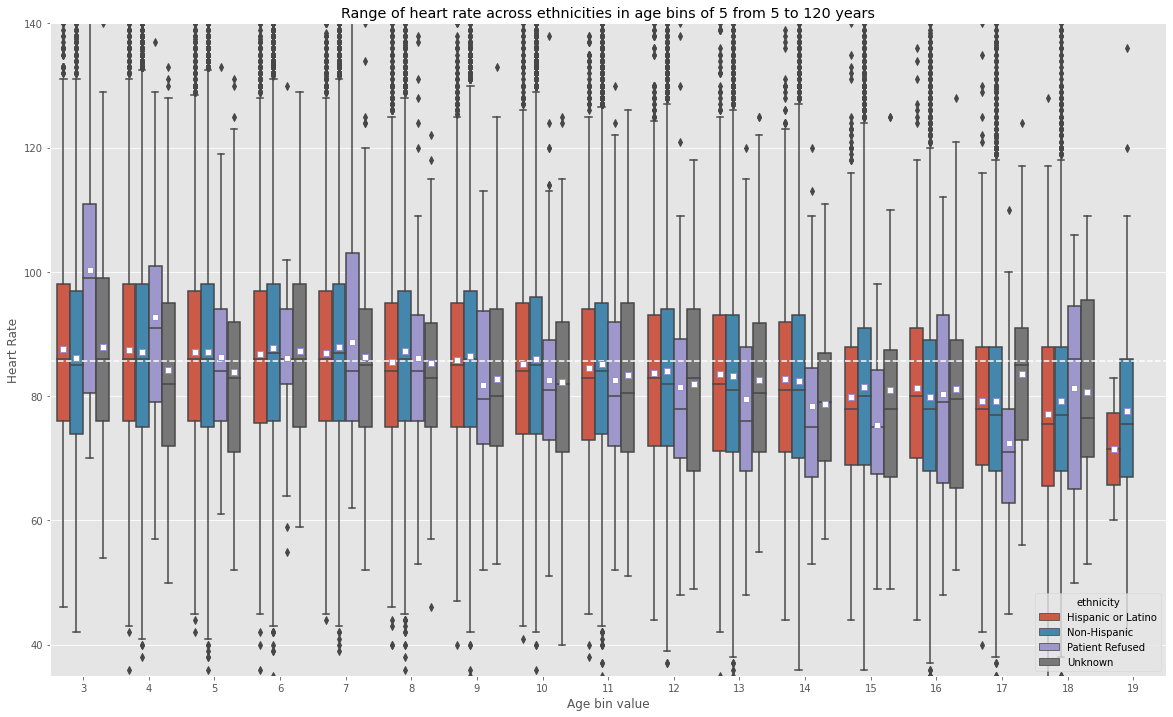

In [0]:
## Binning ages in groups of 5 years
bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 100, 120]
df['age_bin'] = pd.cut(df['age'], bins)
df['age_bin_cat'] = df['age_bin'].astype('category').cat.codes
imputation_check = df[['age_bin_cat','triage_vital_hr', 'gender', 'ethnicity']]
imputation_check['Heart Rate'] =  [round(float(val),2) for val in list(imputation_check['triage_vital_hr'])]
imputation_check['age_bin_cat'].unique()
imputation_check = imputation_check[imputation_check['age_bin_cat'] != -1]

## Box plot of Heart rate per age group categorized by gender
plt.figure(figsize= (15,12))
ax = sns.boxplot(x="age_bin_cat", y="Heart Rate", hue = 'gender', data=imputation_check, showmeans=True,
           meanprops={"marker":"s","markerfacecolor":"white"})


ax.axhline(imputation_check["Heart Rate"].mean(), ls='--', color='white')
plt.title("Range of heart rate across gender in age bins of 5 from 5 to 120 years")
plt.xlabel("Age bin value")
plt.ylim([35, 140])

#### Box plot of Heart rate per age group categorized by ethnicity
plt.figure(figsize= (20,12))
ax = sns.boxplot(x="age_bin_cat", y="Heart Rate", hue = 'ethnicity', data=imputation_check, showmeans=True,
           meanprops={"marker":"s","markerfacecolor":"white"})

ax.axhline(imputation_check["Heart Rate"].mean(), ls='--', color='white')
plt.title("Range of heart rate across ethnicities in age bins of 5 from 5 to 120 years")
plt.xlabel("Age bin value")
plt.ylim([35, 140])
del imputation_check
gc.collect()

In [0]:
# -- reduced_df['disposition_cat'] = reduced_df['disposition'].astype('category').cat.codes

#
for col in reduced_df.columns:
    reduced_df[col] = pd.to_numeric(reduced_df[col], errors='ignore')

## All column names
cols = reduced_df.columns

## Numerical column names
num_cols = reduced_df._get_numeric_data().columns

## Categorical column names
cat_cols2 = list(set(cols) - set(num_cols))
print("Number of categorical columns:",len(cat_cols2))

for cols in cat_cols2:
    reduced_df[cols] = reduced_df[cols].astype('category').cat.codes

col = reduced_df.columns[reduced_df.isnull().mean() >= 0.5]
#print(len(cols))
l = list(set(cols) - set(col))
df_red = reduced_df[[c for c in reduced_df.columns if c in l]]
df_red = df_red.drop('Unnamed: 0', 1)
del reduced_df
data_dict = {'dataset' : df_red}
#pickle.dump(data_dict,open('cleaned_df','wb'))

Impute the dataframe

In [0]:
with open("/content/drive/My Drive/Info_Viz/cleaned_df", "rb") as fp:
    df_red= pickle.load(fp)
reduced_df = df_red['dataset']
cols = reduced_df.columns

## Numerical column names
num_cols = reduced_df._get_numeric_data().columns

## Categorical column names
cat_cols2 = list(set(cols) - set(num_cols))

## Localized imputation across Age groups, Gender and Ethnicity

# Step 1 : Create a list of all unique values in age, Gender and Ethnicity
bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 100, 120]
reduced_df['age_bin'] = pd.cut(reduced_df['age'], bins)
reduced_df['age_bin_cat'] = reduced_df['age_bin'].astype('category').cat.codes
ethnicity_cat = reduced_df['ethnicity'].unique()
age_bin_cat = reduced_df['age_bin_cat'].unique()
gender_cat = reduced_df['gender'].unique()

a = [ethnicity_cat, age_bin_cat, gender_cat]
all_arrays = []
num_cols = list(set(num_cols) - set(['age_bin_cat', 'disposition']))
cat_cols = list(set(cat_cols2 + ['disposition', 'age_bin_cat']))
full_set = num_cols + cat_cols2
## inpute data locally for every unique combination of Age groups, Gender and Ethnicity
for eth, age_bin, gen in list(itertools.product(*a)):
    print("Eth , age, gender" , eth, age_bin, gen)
    subset_df = reduced_df[full_set][(reduced_df['age_bin_cat'] == age_bin) & (reduced_df['gender'] == gen) & (reduced_df['ethnicity'] == eth)]
    subset_num = reduced_df[num_cols][(reduced_df['age_bin_cat'] == age_bin) & (reduced_df['gender'] == gen) & (reduced_df['ethnicity'] == eth)]
    subset_cat = reduced_df[cat_cols2][(reduced_df['age_bin_cat'] == age_bin) & (reduced_df['gender'] == gen) & (reduced_df['ethnicity'] == eth)]
    print("Subset df", subset_df.shape[1])
    if len(subset_df)>0:
        print("Before sum num: " , sum(subset_num.isnull().sum()))
        print("Before sum cat: " , sum(subset_cat.isnull().sum()))
        subset_num.fillna(subset_num.mean(skipna = True), inplace = True)
        subset_cat.fillna(subset_cat.mode(dropna = True).iloc[0], inplace = True)
        print("After sum num: " , sum(subset_num.isnull().sum()))
        print("After sum cat: " , sum(subset_cat.isnull().sum()))
        comb = pd.concat([subset_num, subset_cat], axis = 1)
        all_arrays.append(comb)
imputer_df = pd.concat(all_arrays, axis = 0)
## Making any stray Nulls as 0
imputer_df.fillna(0, inplace = True)
imputer_df['disposition'] = reduced_df['disposition']
data_dict = {'dataset' : imputer_df}
#pickle.dump(data_dict,open('imputer_df','wb'))

Eth , age, gender 0 7 1
Subset df 855
Before sum num:  487201
Before sum cat:  0
After sum num:  61685
After sum cat:  0
Eth , age, gender 0 7 0
Subset df 855
Before sum num:  549686
Before sum cat:  0
After sum num:  65532
After sum cat:  0
Eth , age, gender 0 13 1
Subset df 855
Before sum num:  126641
Before sum cat:  0
After sum num:  16896
After sum cat:  0
Eth , age, gender 0 13 0
Subset df 855
Before sum num:  160759
Before sum cat:  0
After sum num:  21684
After sum cat:  0
Eth , age, gender 0 16 1
Subset df 855
Before sum num:  38746
Before sum cat:  0
After sum num:  7035
After sum cat:  0
Eth , age, gender 0 16 0
Subset df 855
Before sum num:  59595
Before sum cat:  0
After sum num:  9660
After sum cat:  0
Eth , age, gender 0 17 1
Subset df 855
Before sum num:  21182
Before sum cat:  0
After sum num:  3420
After sum cat:  0
Eth , age, gender 0 17 0
Subset df 855
Before sum num:  45288
Before sum cat:  0
After sum num:  8130
After sum cat:  0
Eth , age, gender 0 14 1
Subset df

Memory Reduction of the dataframe

In [0]:
# CITATION: https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65

def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",props[col].dtype)
            print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist


In [0]:
props, NAlist = reduce_mem_usage(imputer_df)
print("_________________")
print("")
print("Warning: the following columns have missing values filled with 'df['column_name'].min() -1': ")
print("_________________")
print("")
print(NAlist)

Memory usage of properties dataframe is : 2261.558786392212  MB
******************************
Column:  meds_diagnostic
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  meds_unclassifieddrugproducts
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  neutrophils_min
dtype before:  int16
dtype after:  uint16
******************************
******************************
Column:  temp_max
dtype before:  int16
dtype after:  uint8
******************************
******************************
Column:  anc(absneutrophilcount)_last
dtype before:  int16
dtype after:  uint16
******************************
******************************
Column:  urineculture,routine_count
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  d-dimer_min
dtype before:  int16
dtype after:  uint16
******************************
**********

In [0]:
with open("/content/drive/My Drive/Info_Viz/opti_df.pkl", 'wb') as handle:
    pickle.dump(props, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
with open("/content/drive/My Drive/Info_Viz/opti_df.pkl", "rb") as fp:
    pro = pickle.load(fp)

In [0]:
# Dividing dataframe as Features and Predictor
y = pro['disposition']
X = pro.loc[:, pro.columns != 'disposition']

#del props
del pro


In [0]:
Y = y.to_frame()
del y

In [0]:
 
# split into 80:20 ratio 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0) 

# describes info about train and test set 
print("Number transactions X_train dataset: ", X_train.shape) 
print("Number transactions y_train dataset: ", y_train.shape) 
print("Number transactions X_test dataset: ", X_test.shape) 
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (448388, 743)
Number transactions y_train dataset:  (448388, 1)
Number transactions X_test dataset:  (112098, 743)
Number transactions y_test dataset:  (112098, 1)


In [0]:
del X
del Y

Since the original data set was too large to be processed using a Non GPU based system, we dropped training data points in 3 options, keeping 70% , 60% and 50% of train rows.
In this process, we didn't disturb test set at all. Test set contains all rows (20% of data) which were split from the original data set.

The intent of using test train split to drop data points was to ensure the distribution of positive and negative cases is still the same in each such combination of train data.


In [0]:
#split the train as 60:40 (Keep 60, drop 40)
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_train, y_train, test_size = 0.4, random_state = 1) 

In [0]:
#split the train as 70:30 (Keep 70, drop 30)
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_train, y_train, test_size = 0.3, random_state = 2) 

In [0]:
#split the train as 50:50 (Keep 50, drop 50)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_train, y_train, test_size = 0.5, random_state = 4) 

In [0]:
## Saving all combinations of train and test data as a pickled dictionary for future usage
final_df = {}
final_df['X_train_a'] = X_train_a
final_df['y_train_a'] = y_train_a
final_df['X_train_b'] = X_train_b
final_df['y_train_b'] = y_train_b
final_df['X_train_c'] = X_train_c
final_df['y_train_c'] = y_train_c
final_df['X_test'] = X_test
final_df['y_test'] = y_test

with open("/content/drive/My Drive/Info_Viz/final_df.pkl", 'wb') as handle:
    pickle.dump(final_df, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [0]:
print(X_train_a.shape)
print(X_train_b.shape)
print(X_train_c.shape)

(224194, 743)


In [0]:
with open("/content/drive/My Drive/Info_Viz/final_df.pkl", "rb") as fp:
    pro = pickle.load(fp)

Using X Train C which is 50% of the train data for training.
In our internal investigation, more data point weren't adding much improvement towards our error metrics.


In [0]:
X_train = pro['X_train_c']
Y_train = (pro['y_train_c'])['disposition']
X_test = pro['X_test']
Y_test = pro['y_test']['disposition']

In [0]:
# XGBOOST Model with Hyperparameter tuning
model = XGBClassifier(seed=42,objective= 'binary:logistic', n_jobs = -1, colsample_bylevel = 0.05)

param_grid = {'max_depth' : [15,20,25],
              'n_estimators' : [20,30,50],
              'learning_rate' : [0.2,0.3,0.4],
              }
#running 3 fold gridsearch CV
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, scoring= ftwo_scorer, verbose = 1)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [0]:
def XGBRun(est):
    model = XGBClassifier(
        max_depth = 15,
        n_estimators=est,
        learning_rate =0.2,
        n_jobs = -1, colsample_bylevel = 0.05,
        objective= 'binary:logistic',
     seed=42)
    return model

In [0]:
y_preds = []
y_proba = []
for est in [10,20,30,40,50,60,70,80,90]:
    print(est)
    xgb_model = XGBRun(est)
    xgb_model.fit(X_train, Y_train)
    y_pred = xgb_model.predict(X_test)
    y_preds.append(y_pred)
    prob = xgb_model.predict_proba(X_test)[:,1]
    y_proba.append(prob)
    print("Confusion Matrix " , confusion_matrix(Y_test, y_pred))
    print("F Beta weighted : ", fbeta_score(Y_test, y_pred, beta=2))
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, prob)
    print("AUC : ", metrics.auc(fpr, tpr))

In [0]:
# Govind to add plotting code here

In [0]:
# hyperparameter tuning:
model_rf = RandomForestClassifier(random_state = 3,n_jobs = -1)
ftwo_scorer = make_scorer(fbeta_score,beta = 2)

param_grid_rf = {'max_depth' : [15,20,25],
              'n_estimators' : [100,200,250]
              }
grid_rf = GridSearchCV(estimator=model_rf, param_grid=param_grid_rf, n_jobs=-1, cv=5, scoring= ftwo_scorer, verbose = 1)
grid_result_rf = grid_rf.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result_rf.best_score_, grid_result_rf.best_params_))






In [0]:
def randomforest(est):
    model = RandomForestClassifier(random_state = 3,max_depth = 15, n_estimators = est,n_jobs = -1)
    return model

In [0]:
y_preds = []
y_proba = []
auc_l = []
fbeta = []
for est in [10,20,30,40,50,60,70,75,80,90,150,250]:
    print(est)
    rf_model = randomforest(est)
    rf_model.fit(X_train, Y_train)
    y_pred = rf_model.predict(X_test)
    y_preds.append(y_pred)
    prob = rf_model.predict_proba(X_test)[:,1]
    y_proba.append(prob)
    print("Confusion Matrix " , confusion_matrix(Y_test, y_pred))
    print("F Beta weighted : ", fbeta_score(Y_test, y_pred, beta=2))
    fbeta.append(fbeta_score(Y_test, y_pred, beta=2))
    fpr, tpr, thresholds = roc_curve(Y_test, prob)
    print("AUC : ", auc(fpr, tpr))
    auc_l.append(auc(fpr, tpr))

10
Confusion Matrix  [[19119 14348]
 [ 3140 75491]]
F Beta weighted :  0.9334558305285103
AUC :  0.8950983748007918
20
Confusion Matrix  [[19246 14221]
 [ 2961 75670]]
F Beta weighted :  0.9355488792453298
AUC :  0.9007364725567502
30
Confusion Matrix  [[19419 14048]
 [ 2944 75687]]
F Beta weighted :  0.9361201605901167
AUC :  0.902475765558042
40
Confusion Matrix  [[19329 14138]
 [ 2883 75748]]
F Beta weighted :  0.9365248139264609
AUC :  0.9022206863792822
50
Confusion Matrix  [[19392 14075]
 [ 2868 75763]]
F Beta weighted :  0.9368214619573552
AUC :  0.9034017703290431
60
Confusion Matrix  [[19408 14059]
 [ 2877 75754]]
F Beta weighted :  0.9367680919628923
AUC :  0.9036516371679437
70
Confusion Matrix  [[19421 14046]
 [ 2883 75748]]
F Beta weighted :  0.9367379142160379
AUC :  0.9042059135467657
75
Confusion Matrix  [[19395 14072]
 [ 2851 75780]]
F Beta weighted :  0.936999228440857
AUC :  0.9042220023924004
80
Confusion Matrix  [[19413 14054]
 [ 2858 75773]]
F Beta weighted :  0.9

In [0]:
pickle.dump({"Pred" : y_preds, "Prob" :y_proba} , open("RF_C_15est", "wb"))

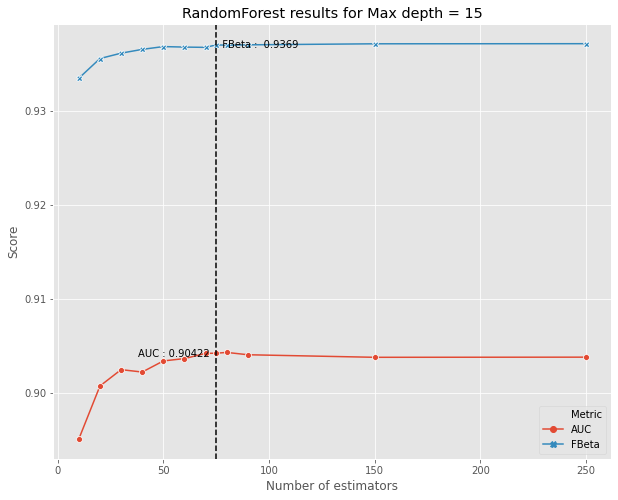

In [0]:
n_estimators = [10,20,30,40,50,60,70,75,80,90,150,250]
plot_data = pd.DataFrame({"Estimators" :n_estimators , "AUC" : auc_l , "FBeta" : fbeta})
melt_df = pd.melt(plot_data, value_vars=['AUC', 'FBeta'])

melt_df["Estimators"] =[10,20,30,40,50,60,70,75,80,90,150,250,10,20,30,40,50,60,70,75,80,90,150,250]
melt_df = melt_df.rename(columns={"variable": "Metric"})

ax = sns.lineplot(x="Estimators", y="value",
                  hue="Metric", style="Metric",
                  markers=True, dashes=False, data=melt_df)

ax.axvline(75, ls='--', color='black')

ax.text( 75, 0.90420, s= "AUC : 0.90422  ", color='black', horizontalalignment='right',verticalalignment='center')
ax.text( 75, 0.9370, s= "  FBeta :  0.9369", color='black', horizontalalignment='left',verticalalignment='center')

plt.xlabel('Number of estimators')
plt.ylabel('Score')
plt.title('RandomForest results for Max depth = 15')
plt.show()


#ax.axvline(40, ls='--', color='black')

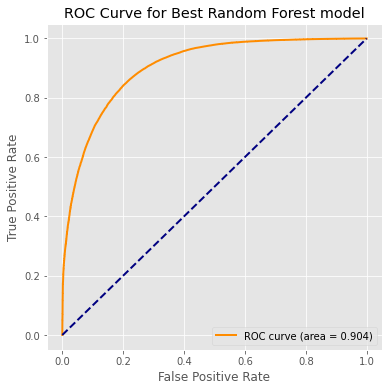

In [0]:
plt.figure(figsize= (6,6))
lw = 2
fpr, tpr, thresholds = roc_curve(Y_test, y_proba[7])
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f)' % 0.90422)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Best Random Forest model')
plt.legend(loc="lower right")
plt.show()

In [0]:
#Calculating Feature Importance:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X_train,Y_train.ravel())
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, columns=X_.columns)

In [0]:
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)

In [0]:
feat_imp = feat_importances.to_frame().reset_index()

In [0]:
#print(feat_imp)
feat_imp = feat_imp.rename(columns={'index': 'features', 0: 'importance'})
print(feat_imp)

                                 features  importance
0                         meds_diagnostic    0.000778
1           meds_unclassifieddrugproducts    0.006275
2                         neutrophils_min    0.001187
3                                temp_max    0.001955
4            anc(absneutrophilcount)_last    0.001019
..                                    ...         ...
738                      cc_multiplefalls    0.000144
739                  cc_seizure-priorhxof    0.000341
740  suicideandintentionalselfinflictedin    0.000479
741                     cc_epigastricpain    0.000212
742                     cc_facialswelling    0.000194

[743 rows x 2 columns]


In [0]:
#sort the features in descending  based on importance
feature_imp = feat_imp.sort_values(by=['importance'], ascending=False)


In [0]:
with open("/content/drive/My Drive/Info_Viz/feature_imp.pkl", 'wb') as handle:
    pickle.dump(feature_imp, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
# Visualisation of feature importance using a divergent plot by taking the top 20 features

#features list:
with open("/content/drive/My Drive/Info Viz/feature_imp.pkl", "rb") as fp:
    f_i = pickle.load(fp)

In [0]:
print(f_i)
f_t = f_i.head(20)

                        features  importance
74                           esi    0.044324
348          meds_cardiovascular    0.032196
42                           age    0.017116
192  meds_psychotherapeuticdrugs    0.016399
154        meds_gastrointestinal    0.015960
..                           ...         ...
457                  perintjaund    0.000000
487              ecodesmachinery    0.000000
581            ecodessuffocation    0.000000
362    bloodculture,routine_npos    0.000000
429      septicemiaexceptinlabor    0.000000

[743 rows x 2 columns]


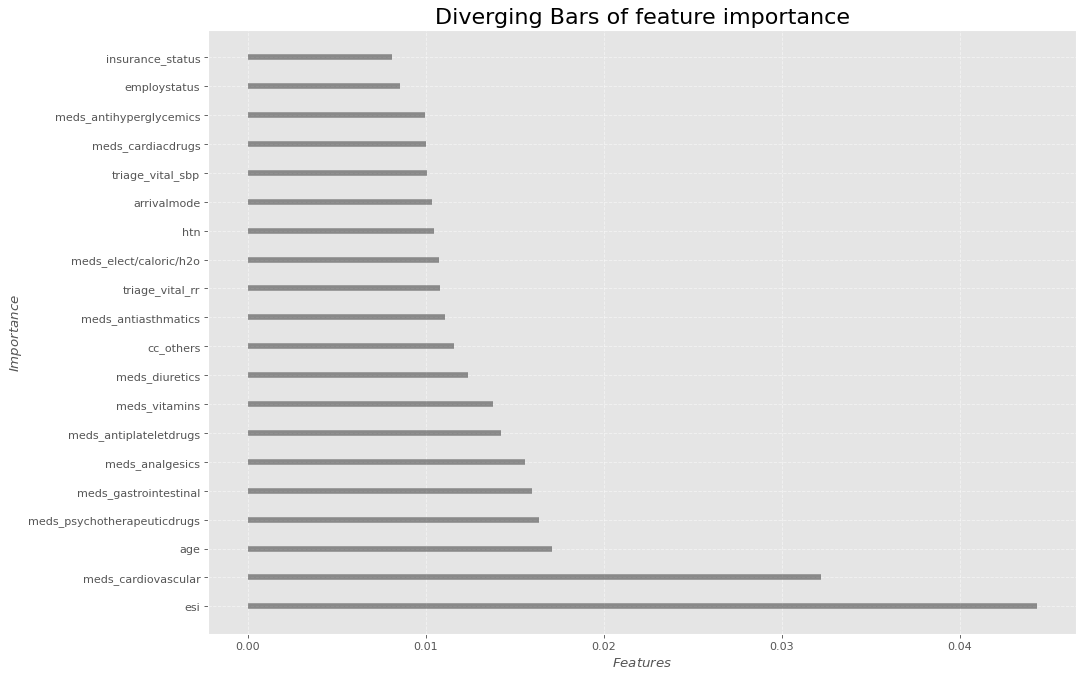

In [0]:

plt.figure(figsize=(14,10), dpi= 80)
plt.hlines(y=f_t.features, xmin=0, xmax=f_t.importance, alpha=0.4, linewidth=5)


plt.gca().set(ylabel='$Importance$', xlabel='$Features$')
plt.title('Diverging Bars of feature importance', fontdict={'size':20})
plt.grid(linestyle='--', alpha=0.5)
plt.show()